In [1]:
# try:
#     import zarr
# except: 
#     !cp -r '/kaggle/input/hengck-czii-cryo-et-01/wheel_file' '/kaggle/working/'
#     !pip install /kaggle/working/wheel_file/asciitree-0.3.3/asciitree-0.3.3
#     !pip install --no-index --find-links=/kaggle/working/wheel_file zarr
#     !pip install --no-index --find-links=/kaggle/working/wheel_file connected-components-3d

# print('PIP INSTALL OK!!!')

In [2]:
from datetime import datetime
import pytz

import sys
sys.path.append('yolo11_try/hengck')

from czii_helper import *
from dataset import *
from model2 import *

In [3]:
from volumentations import *
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from schedulefree import RAdamScheduleFree
import glob
import os
import gc
import tqdm
import cc3d
from scipy.optimize import linear_sum_assignment

In [4]:
WINDOW_SIZE = 16
BATCH_SIZE = 2
AUGMENTATION_LIB = "A"  # or "V"
EPOCHS = 10
# make dataset
STATIC_DIR = "../raw/train/static/ExperimentRuns"
OVERLAY_DIR = "../proc/create_3d_mask"
# PARTICLE = [
#     'apo-ferritin',
#     'beta-amylase',
#     'beta-galactosidase',
#     'ribosome',
#     'thyroglobulin',
#     'virus-like-particle',
# ]
train_id = [
    "TS_69_2",
    "TS_6_4",
    "TS_6_6",
    "TS_73_6",
    "TS_86_3",
    "TS_99_9",
]  # "TS_6_4", "TS_6_6", "TS_73_6", "TS_86_3", "TS_99_9"]
valid_id = ["TS_5_4"]

cfg = dotdict(
    arch ='resnet34d',
    # checkpoint=\
    # '/kaggle/input/cryoet-2-5dim-model/model_160.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

In [5]:
# load images and labels
volumes = {}
masks = {}
# get all image depth
train_ds = []
for _id in train_id:
    volume = read_one_data(_id, STATIC_DIR)
    D, H, W = volume.shape
    train_ds.append(D)
    volume = np.pad(
        volume,
        [[0, 0], [0, 640 - H], [0, 640 - W]],
        mode="constant",
        constant_values=0,
    )
    volumes[_id] = volume
    masks[_id] = np.load(f"{OVERLAY_DIR}/{_id}.npy", mmap_mode="r").astype(np.int64)

valid_ds = []
for _id in valid_id:
    volume = read_one_data(_id, STATIC_DIR)
    D, H, W = volume.shape
    valid_ds.append(D)
    volume = np.pad(
        volume,
        [[0, 0], [0, 640 - H], [0, 640 - W]],
        mode="constant",
        constant_values=0,
    )
    volumes[_id] = volume
    masks[_id] = np.load(f"{OVERLAY_DIR}/{_id}.npy", mmap_mode="r").astype(np.int64)

start_and_ids = []
for i, id in enumerate(train_id):
    for start in range(train_ds[i] - WINDOW_SIZE):
        start_and_ids.append((start, id))

In [6]:
print(len(start_and_ids))

1008


In [7]:
class TrainDataset(Dataset):
    def __init__(self, start_and_ids, overlay_dir):
        self.ids = start_and_ids
        self.overlay_dir = overlay_dir
        if AUGMENTATION_LIB == "A":
            self.transform = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    # A.CubicSymmetry(p=0.5),
                    # A.RandomBrightnessContrast(p=0.2),
                    # A.GaussNoise(p=0.2),
                ]
            )
        elif AUGMENTATION_LIB == "V":
            self.transform = Compose(
                [
                    Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
                    Flip(0, p=0.5),
                    Flip(1, p=0.5),
                    Flip(2, p=0.5),
                    RandomRotate90((1, 2), p=0.5),
                    GaussianNoise(var_limit=(0, 5), p=0.2),
                    RandomGamma(gamma_limit=(80, 120), p=0.2),
                ],
                p=0.8,
            )

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # print(self.ids[idx])
        start, _id = self.ids[idx]
        # ランダムな位置からウィンドウサイズ分のデータを取得
        volume = volumes[_id]
        mask = masks[_id]
        D, H, W = volume.shape

        volume = volume[start : start + WINDOW_SIZE]
        mask = mask[start : start + WINDOW_SIZE].astype(np.int64)

        if AUGMENTATION_LIB == "A":
            transformed = self.transform(volume=volume, mask3d=mask)
            # print(image.shape, sub_label.shape)
            return transformed["volume"], transformed["mask3d"]
        elif AUGMENTATION_LIB == "V":
            transformed = self.transform(image=volume, mask=mask)
            return transformed["image"], transformed["mask"]
        else:
            raise NotImplementedError


In [8]:
model = Net(pretrained=True, cfg=dotdict({"arch": "resnet18d"}))
model.cuda()

train_dataset = TrainDataset(start_and_ids, OVERLAY_DIR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = RAdamScheduleFree(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_59874/28315065.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:

def probability_to_location(probability, cfg):
    _, D, H, W = probability.shape

    location = {}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(
            probability[l] > cfg.threshold[p.name], return_N=True
        )
        stats = cc3d.statistics(cc)
        zyx = stats["centroids"][1:] * 10
        xyz = np.ascontiguousarray(zyx[:, ::-1])
        location[p.name] = xyz
        """
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        """
    return location


def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz) > 0:
            df = pd.DataFrame(data=xyz, columns=["x", "y", "z"])
            # df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column="particle_type", value=p.name)
            location_df.append(df)
    if len(location_df) > 0:
        location_df = pd.concat(location_df)
    else:
        location_df = pd.DataFrame(columns=["particle_type", "x", "y", "z"])
    return location_df


In [10]:
def train_one_epoch():
    model.train()
    optimizer.train()
    total_loss = 0
    optimizer.zero_grad()  # Reset gradients at the start of each epoch
    for i, (image, label) in enumerate(tqdm.tqdm(train_loader)):
        label = label.long()
        batch = {"image": image, "mask": label}
        with torch.autocast(device_type="cuda"):
            output = model(batch)
            loss = output["mask_loss"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()
    return total_loss / len(train_loader)


def valid_one_epoch():
    model.eval()
    optimizer.eval()
    mask = masks[valid_id[0]]
    volume = volumes[valid_id[0]]
    total_loss = 0
    probability = np.zeros((7, 184, 630, 630), dtype=np.float32)
    count = np.zeros((7, 184, 630, 630), dtype=np.float32)
    for start in tqdm.tqdm(range(train_ds[i] - WINDOW_SIZE)):
        image = volume[start : start + WINDOW_SIZE]
        sub_mask = mask[start : start + WINDOW_SIZE]
        image = torch.from_numpy(image).unsqueeze(0).float().cuda()
        sub_mask = torch.from_numpy(sub_mask).unsqueeze(0).long().cuda()
        batch = {"image": image, "mask": sub_mask}
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                output = model(batch)
        total_loss += output["mask_loss"]
        prob = output["particle"][0].cpu().numpy()
        probability[:, start : start + WINDOW_SIZE] += prob[:, :, :H, :W]
        count[:, start : start + WINDOW_SIZE] += 1
        del image, sub_mask, batch
        gc.collect()
        # print(loss.item())
    probability = probability / (count + 0.0001)
    location = probability_to_location(probability, cfg)
    df = location_to_df(location)
    df.insert(loc=0, column="experiment", value=id)
    return total_loss.item() / (train_ds[i] - WINDOW_SIZE), df

def do_one_eval(truth, predict, threshold):
    P = len(predict)
    T = len(truth)

    if P == 0:
        hit = [[], []]
        miss = np.arange(T).tolist()
        fp = []
        metric = [P, T, len(hit[0]), len(miss), len(fp)]
        return hit, fp, miss, metric

    if T == 0:
        hit = [[], []]
        fp = np.arange(P).tolist()
        miss = []
        metric = [P, T, len(hit[0]), len(miss), len(fp)]
        return hit, fp, miss, metric

    # ---
    distance = predict.reshape(P, 1, 3) - truth.reshape(1, T, 3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss, t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp, p_index)].tolist()

    metric = [P, T, len(hit[0]), len(miss), len(fp)]  # for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df["experiment"].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(
            id, overlay_dir
        )  # =f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df["experiment"] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print("\r", id, p.name, end="", flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df["particle_type"] == p.name][
                ["x", "y", "z"]
            ].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius * 0.5)
            eval_df.append(
                dotdict(
                    id=id,
                    particle_type=p.name,
                    P=metric[0],
                    T=metric[1],
                    hit=metric[2],
                    miss=metric[3],
                    fp=metric[4],
                )
            )
    print("")
    # 例外処理を追加
    try:  
        eval_df = pd.DataFrame(eval_df)
        gb = eval_df.groupby("particle_type").agg("sum").drop(columns=["id"])
        gb.loc[:, "precision"] = gb["hit"] / gb["P"]
        gb.loc[:, "precision"] = gb["precision"].fillna(0)
        gb.loc[:, "recall"] = gb["hit"] / gb["T"]
        gb.loc[:, "recall"] = gb["recall"].fillna(0)
        gb.loc[:, "f-beta4"] = (
            17 * gb["precision"] * gb["recall"] / (16 * gb["precision"] + gb["recall"])
        )
        gb.loc[:, "f-beta4"] = gb["f-beta4"].fillna(0)

        gb = gb.sort_values("particle_type").reset_index(drop=False)
        # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
        gb.loc[:, "weight"] = [1, 0, 2, 1, 2, 1]
        lb_score = (gb["f-beta4"] * gb["weight"]).sum() / gb["weight"].sum()
        return gb, lb_score
    except Exception as e:
        print(f'エラーが発生しました: {e}')
        return None, 0.0
    

def check_eval(submit_df):
    gb, lb_score = compute_lb(
        submit_df,
        "../raw/train/overlay/ExperimentRuns",
    )
    print(gb)
    print("lb_score:", lb_score)
    print("")

    # show one ----------------------------------
    fig = plt.figure(figsize=(18, 8))

    id = valid_id[0]
    truth = read_one_truth(
        id,
        overlay_dir="../raw/train/overlay/ExperimentRuns",
    )

    submit_df = submit_df[submit_df["experiment"] == id]
    for p in PARTICLE:
        p = dotdict(p)
        xyz_truth = truth[p.name]
        xyz_predict = submit_df[submit_df["particle_type"] == p.name][
            ["x", "y", "z"]
        ].values
        hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
        print(id, p.name)
        print("\t num truth   :", len(xyz_truth))
        print("\t num predict :", len(xyz_predict))
        print("\t num hit  :", len(hit[0]))
        print("\t num fp   :", len(fp))
        print("\t num miss :", len(miss))

        ax = fig.add_subplot(2, 3, p.label, projection="3d")
        if hit[0]:
            pt = xyz_predict[hit[0]]
            ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color="r")
            pt = xyz_truth[hit[1]]
            ax.scatter(
                pt[:, 0],
                pt[:, 1],
                pt[:, 2],
                s=80,
                facecolors="none",
                edgecolors="r",
            )
        if fp:
            pt = xyz_predict[fp]
            ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color="k")
        if miss:
            pt = xyz_truth[miss]
            ax.scatter(
                pt[:, 0],
                pt[:, 1],
                pt[:, 2],
                s=160,
                alpha=1,
                facecolors="none",
                edgecolors="k",
            )

        ax.set_title(f"{p.name} ({p.difficulty})")

    plt.tight_layout()
    # plt.show()
    plt.savefig("../proc/2-5d-model/eval.png")

    return lb_score


epoch: 0


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:28<00:00,  1.91it/s]


train_loss: 0.878043169717467, valid_loss: 0.42377149491083055
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type   P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  19  36    0    36  19        0.0     0.0      0.0   
1         beta-amylase   1  21    0    21   1        0.0     0.0      0.0   
2   beta-galactosidase   1  24    0    24   1        0.0     0.0      0.0   
3             ribosome   1  65    0    65   1        0.0     0.0      0.0   
4        thyroglobulin   1  49    0    49   1        0.0     0.0      0.0   
5  virus-like-particle   1  13    0    13   1        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num 

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:35<00:00,  1.77it/s]


train_loss: 0.17450649347451944, valid_loss: 0.06507668041047596
epoch: 2


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:33<00:00,  1.80it/s]


train_loss: 0.02676024937462653, valid_loss: 0.014967689911524454
epoch: 3


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:47<00:00,  1.56it/s]


train_loss: 0.0076014710643831345, valid_loss: 0.005688324925445375
epoch: 4


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


train_loss: 0.003341342706421745, valid_loss: 0.0028635969474202112
epoch: 5


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:25<00:00,  1.97it/s]


train_loss: 0.0018655349452432895, valid_loss: 0.0017516744278726123
epoch: 6


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:27<00:00,  1.93it/s]


train_loss: 0.0011990403770127274, valid_loss: 0.0011644531041383743
epoch: 7


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.83it/s]


train_loss: 0.0008427335507428599, valid_loss: 0.0008291226057779221
epoch: 8


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:26<00:00,  1.93it/s]


train_loss: 0.0006298848894070871, valid_loss: 0.0006183341500304994
epoch: 9


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


train_loss: 0.000491357456219645, valid_loss: 0.0005265413561747188
epoch: 10


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:25<00:00,  1.95it/s]


train_loss: 0.0003932290191375022, valid_loss: 0.00037445669018086933
[]

エラーが発生しました: 'particle_type'
None
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 12
TS_5_4 ribosome
	 num truth   : 31
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 31
TS_5_4 thyroglobulin
	 num truth   : 30
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 30
TS_5_4 virus-like-particle
	 num truth   : 11
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 11
epoch: 11


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:28<00:00,  1.90it/s]


train_loss: 0.00032215200998406444, valid_loss: 0.0003381953574717045
epoch: 12


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:28<00:00,  1.89it/s]


train_loss: 0.0002697577477062753, valid_loss: 0.00027228002658202533
epoch: 13


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:28<00:00,  1.90it/s]


train_loss: 0.0002292030223023695, valid_loss: 0.00027568600628347626
epoch: 14


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:29<00:00,  1.88it/s]


train_loss: 0.00019651459897720506, valid_loss: 0.00024031787844640867
epoch: 15


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:29<00:00,  1.89it/s]


train_loss: 0.0001701085632284669, valid_loss: 0.00018081639982050373
epoch: 16


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:26<00:00,  1.93it/s]


train_loss: 0.0001485216113097623, valid_loss: 0.00015057045744643326
epoch: 17


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


train_loss: 0.00012883546132220618, valid_loss: 0.00012436991424432823
epoch: 18


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.84it/s]


train_loss: 0.00011508710599989013, valid_loss: 0.00011368997261992522
epoch: 19


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:29<00:00,  1.88it/s]


train_loss: 0.00010508461542442438, valid_loss: 0.00010106820125310194
epoch: 20


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:29<00:00,  1.87it/s]


train_loss: 9.713212076016972e-05, valid_loss: 9.763398252072788e-05
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  1  36    0    36   1        0.0     0.0      0.0   
1         beta-amylase  0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase  0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  0  65    0    65   0        0.0     0.0      0.0   
4        thyroglobulin  0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle  0  13    0    13   0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num p

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:30<00:00,  1.86it/s]


train_loss: 9.058861056899563e-05, valid_loss: 9.48160332405851e-05
epoch: 22


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.83it/s]


train_loss: 8.517428178341409e-05, valid_loss: 0.00010239227586204098
epoch: 23


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.83it/s]


train_loss: 8.03607605023769e-05, valid_loss: 0.00010145146266690322
epoch: 24


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:30<00:00,  1.85it/s]


train_loss: 7.581411856039816e-05, valid_loss: 9.829407956983362e-05
epoch: 25


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.83it/s]


train_loss: 7.117975478072439e-05, valid_loss: 0.00010254678671203909
epoch: 26


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.84it/s]


train_loss: 6.601749265384915e-05, valid_loss: 9.611484018110094e-05
epoch: 27


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:43<00:00,  1.62it/s]


train_loss: 6.067795777472918e-05, valid_loss: 9.367841162851878e-05
epoch: 28


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:30<00:00,  1.85it/s]


train_loss: 5.675342104510376e-05, valid_loss: 9.739718266895839e-05
epoch: 29


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.74it/s]


train_loss: 5.338337081658059e-05, valid_loss: 8.959309308834019e-05
epoch: 30


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.84it/s]


train_loss: 5.0678305456131056e-05, valid_loss: 9.651075205987408e-05
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  5  36    0    36   5        0.0     0.0      0.0   
1         beta-amylase  0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase  0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  0  65    0    65   0        0.0     0.0      0.0   
4        thyroglobulin  0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle  0  13    0    13   0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num 

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:33<00:00,  1.80it/s]


train_loss: 4.7030677339511575e-05, valid_loss: 8.851150050759315e-05
epoch: 32


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:34<00:00,  1.78it/s]


train_loss: 4.4186842970361795e-05, valid_loss: 9.399250016680785e-05
epoch: 33


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:37<00:00,  1.73it/s]


train_loss: 4.123025719807733e-05, valid_loss: 0.00010284560821240856
epoch: 34


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:35<00:00,  1.76it/s]


train_loss: 3.882970793707529e-05, valid_loss: 0.00011099116610629218
epoch: 35


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.84it/s]


train_loss: 3.589379146178084e-05, valid_loss: 0.00011250403310571398
epoch: 36


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:30<00:00,  1.86it/s]


train_loss: 3.399166838742342e-05, valid_loss: 0.00010657039958806265
epoch: 37


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


train_loss: 3.15861014901678e-05, valid_loss: 0.00011133828333445958
epoch: 38


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


train_loss: 2.9947914334913083e-05, valid_loss: 0.00011754985011759258
epoch: 39


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


train_loss: 2.7632475536842365e-05, valid_loss: 0.00012101203070155211
epoch: 40


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:30<00:00,  1.86it/s]


train_loss: 2.667310416104045e-05, valid_loss: 0.00011797224925387473
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  5  36    0    36   5        0.0     0.0      0.0   
1         beta-amylase  0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase  0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  2  65    0    65   2        0.0     0.0      0.0   
4        thyroglobulin  0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle  0  13    0    13   0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num 

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:33<00:00,  1.80it/s]


train_loss: 2.4668970803696866e-05, valid_loss: 0.00011973124041798569
epoch: 42


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:37<00:00,  1.72it/s]


train_loss: 2.343420741194507e-05, valid_loss: 0.00012172157654450053
epoch: 43


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:35<00:00,  1.77it/s]


train_loss: 2.1759973764127034e-05, valid_loss: 0.00011938569756845634
epoch: 44


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:32<00:00,  1.81it/s]


train_loss: 2.051854150956229e-05, valid_loss: 0.0001244711068769296
epoch: 45


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


train_loss: 1.9787720361383807e-05, valid_loss: 0.00012286236908818995
epoch: 46


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:31<00:00,  1.83it/s]


train_loss: 1.905542922243688e-05, valid_loss: 0.0001242345842044978
epoch: 47


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:33<00:00,  1.79it/s]


train_loss: 1.709806358315572e-05, valid_loss: 0.00012850376688653515
epoch: 48


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:47<00:00,  1.56it/s]


train_loss: 1.6815191161315883e-05, valid_loss: 0.00012466334737837315
epoch: 49


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:33<00:00,  1.80it/s]


train_loss: 1.5839652039659335e-05, valid_loss: 0.00012530359838690077
epoch: 50


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:34<00:00,  1.77it/s]


train_loss: 1.5108508018644797e-05, valid_loss: 0.0001243376505694219
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type   P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  13  36    0    36  13        0.0     0.0      0.0   
1         beta-amylase   0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase   0  24    0    24   0        0.0     0.0      0.0   
3             ribosome   1  65    0    65   1        0.0     0.0      0.0   
4        thyroglobulin   0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle   2  13    0    13   2        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.74it/s]


train_loss: 1.3958733282126359e-05, valid_loss: 0.00012346055536043075
epoch: 52


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:37<00:00,  1.73it/s]


train_loss: 1.3806041097586339e-05, valid_loss: 0.00012896725508783544
epoch: 53


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:48<00:00,  1.55it/s]


train_loss: 1.2940218730707354e-05, valid_loss: 0.00012521779475112757
epoch: 54


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:35<00:00,  1.76it/s]


train_loss: 1.1909014033865323e-05, valid_loss: 0.0001270931014525039
epoch: 55


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:49<00:00,  1.53it/s]


train_loss: 1.191124360521033e-05, valid_loss: 0.0001280364646975483
epoch: 56


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:34<00:00,  1.77it/s]


train_loss: 1.1300507426501854e-05, valid_loss: 0.00013002429512285052
epoch: 57


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:34<00:00,  1.77it/s]


train_loss: 1.0973620394906183e-05, valid_loss: 0.00012528127990663052
epoch: 58


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:34<00:00,  1.79it/s]


train_loss: 1.0505042728957217e-05, valid_loss: 0.0001275702490515652
epoch: 59


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:35<00:00,  1.76it/s]


train_loss: 9.883819911339213e-06, valid_loss: 0.00013173273986294155
epoch: 60


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:33<00:00,  1.80it/s]


train_loss: 9.492549800006061e-06, valid_loss: 0.00013170566498523666
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type   P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  11  36    0    36  11        0.0     0.0      0.0   
1         beta-amylase   0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase   0  24    0    24   0        0.0     0.0      0.0   
3             ribosome   7  65    0    65   7        0.0     0.0      0.0   
4        thyroglobulin   0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle   3  13    0    13   3        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.75it/s]


train_loss: 9.251601290832183e-06, valid_loss: 0.0001352368188755853
epoch: 62


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.74it/s]


train_loss: 8.67410502125268e-06, valid_loss: 0.00013765798039024784
epoch: 63


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:35<00:00,  1.76it/s]


train_loss: 8.479699322728423e-06, valid_loss: 0.00013882675695986975
epoch: 64


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.74it/s]


train_loss: 8.00626587830614e-06, valid_loss: 0.00013805766190801348
epoch: 65


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.74it/s]


train_loss: 7.810901120283841e-06, valid_loss: 0.00013756074587858858
epoch: 66


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:37<00:00,  1.73it/s]


train_loss: 7.597421394083929e-06, valid_loss: 0.00014033217337869463
epoch: 67


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:37<00:00,  1.73it/s]


train_loss: 7.295517579435855e-06, valid_loss: 0.000131496616328756
epoch: 68


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


train_loss: 7.092675566132786e-06, valid_loss: 0.00014209431330008165
epoch: 69


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.73it/s]


train_loss: 6.789301189503443e-06, valid_loss: 0.0001403649692379293
epoch: 70


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:37<00:00,  1.72it/s]


train_loss: 6.503917189427877e-06, valid_loss: 0.00014010231409754072
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  8  36    0    36   8        0.0     0.0      0.0   
1         beta-amylase  0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase  0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  8  65    0    65   8        0.0     0.0      0.0   
4        thyroglobulin  0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle  2  13    0    13   2        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num 

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


train_loss: 6.132180603480987e-06, valid_loss: 0.0001418545420858122
epoch: 72


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.74it/s]


train_loss: 6.034583719790977e-06, valid_loss: 0.0001408629828975314
epoch: 73


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.73it/s]


train_loss: 5.762726932236172e-06, valid_loss: 0.00014584601324583803
epoch: 74


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:39<00:00,  1.70it/s]


train_loss: 5.665272950537328e-06, valid_loss: 0.00014985048966038796
epoch: 75


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


train_loss: 5.693336507348618e-06, valid_loss: 0.00013967605662487803
epoch: 76


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


train_loss: 5.17830527153036e-06, valid_loss: 0.00014151506392019137
epoch: 77


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


train_loss: 5.020227914523875e-06, valid_loss: 0.0001391767014172815
epoch: 78


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:36<00:00,  1.73it/s]


train_loss: 5.165399439365279e-06, valid_loss: 0.00014459040193330673
epoch: 79


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


train_loss: 4.929710237335291e-06, valid_loss: 0.0001435197911979187
epoch: 80


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


train_loss: 4.7534067954520186e-06, valid_loss: 0.00014601489307270165
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type   P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin   8  36    0    36   8        0.0     0.0      0.0   
1         beta-amylase   0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase   0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  10  65    0    65  10        0.0     0.0      0.0   
4        thyroglobulin   0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle   1  13    0    13   1        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 1

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:39<00:00,  1.68it/s]


train_loss: 4.2399949887966185e-06, valid_loss: 0.00014861979122672762
epoch: 82


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:41<00:00,  1.66it/s]


train_loss: 4.5715892770539115e-06, valid_loss: 0.00014820702684422335
epoch: 83


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


train_loss: 4.7131240384482685e-06, valid_loss: 0.000143946214978184
epoch: 84


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


train_loss: 4.262771053115562e-06, valid_loss: 0.00014146482793702964
epoch: 85


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.68it/s]


train_loss: 4.005204635962763e-06, valid_loss: 0.00014315447991802578
epoch: 86


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


train_loss: 4.0082779608289665e-06, valid_loss: 0.00014947792736902122
epoch: 87


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


train_loss: 3.6106478903749583e-06, valid_loss: 0.0001457686247747569
epoch: 88


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:41<00:00,  1.66it/s]


train_loss: 3.6646412624745625e-06, valid_loss: 0.0001549241909136375
epoch: 89


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.66it/s]


train_loss: 3.5479794798862162e-06, valid_loss: 0.00015150651424413635
epoch: 90


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


train_loss: 3.7351760782626112e-06, valid_loss: 0.00015067459926718758
['TS_99_9']
 TS_99_9 virus-like-particle
         particle_type   P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  10  36    0    36  10        0.0     0.0      0.0   
1         beta-amylase   0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase   0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  10  65    0    65  10        0.0     0.0      0.0   
4        thyroglobulin   1  49    0    49   1        0.0     0.0      0.0   
5  virus-like-particle   6  13    0    13   6        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 1

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:44<00:00,  1.60it/s]


train_loss: 3.410258217250699e-06, valid_loss: 0.0001561797024416072
epoch: 92


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


train_loss: 3.330069370925692e-06, valid_loss: 0.00015441130935436203
epoch: 93


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:41<00:00,  1.65it/s]


train_loss: 3.3110639323870517e-06, valid_loss: 0.00015252303065998212
epoch: 94


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:43<00:00,  1.63it/s]


train_loss: 3.448329354360835e-06, valid_loss: 0.0001439687219404039
epoch: 95


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:48<00:00,  1.54it/s]


train_loss: 3.3175056953011456e-06, valid_loss: 0.00014828637774501528
epoch: 96


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:44<00:00,  1.60it/s]


train_loss: 3.1089256630419315e-06, valid_loss: 0.00015507315817688192
epoch: 97


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:59<00:00,  1.40it/s]


train_loss: 3.081075263777039e-06, valid_loss: 0.00014794441605252878
epoch: 98


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:42<00:00,  1.63it/s]


train_loss: 2.749296545482917e-06, valid_loss: 0.0001422576717145386
epoch: 99


  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_59874/1587794456.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 168/168 [01:42<00:00,  1.64it/s]


train_loss: 2.6957850080148103e-06, valid_loss: 0.00016121790256528627


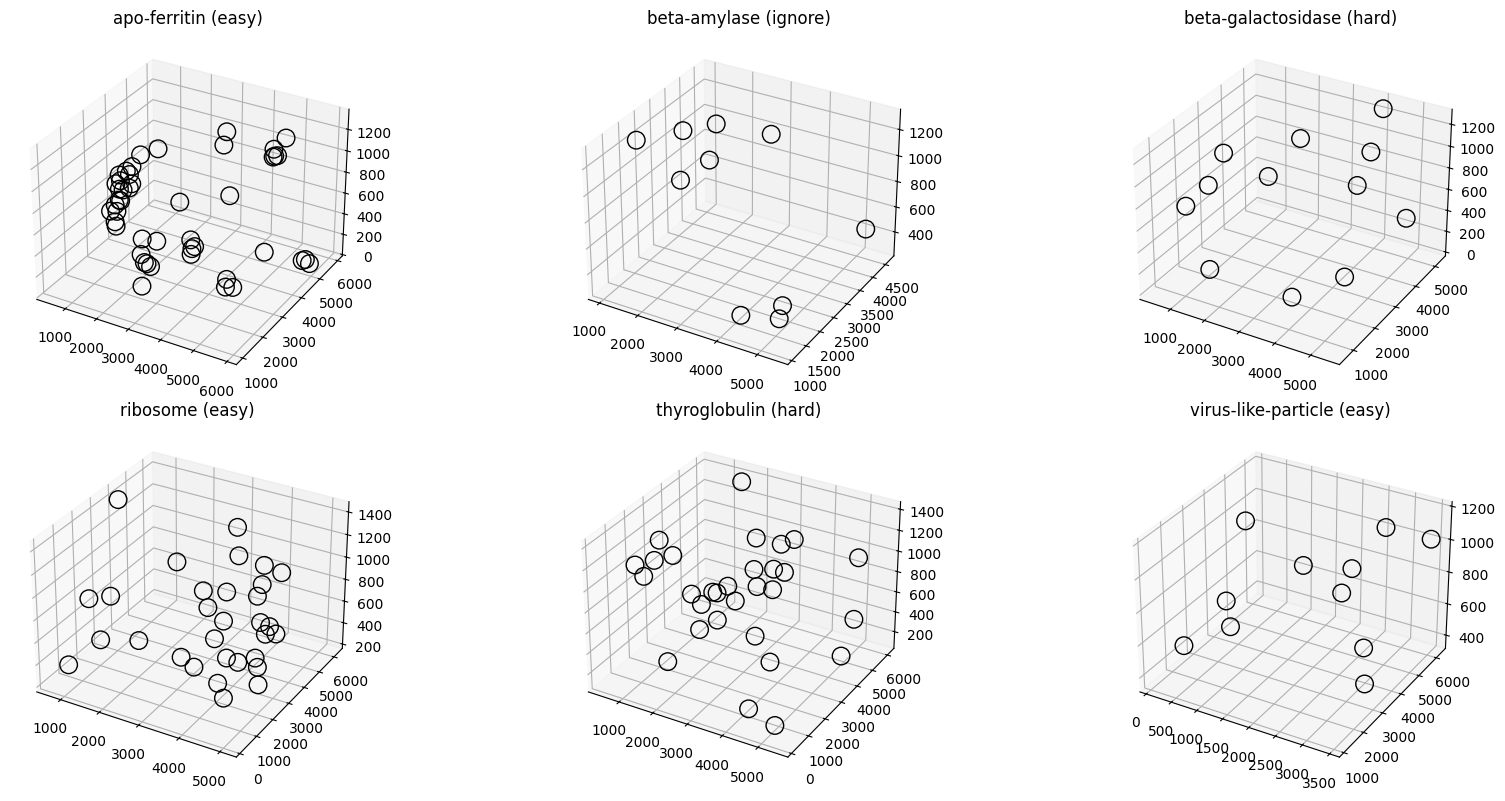

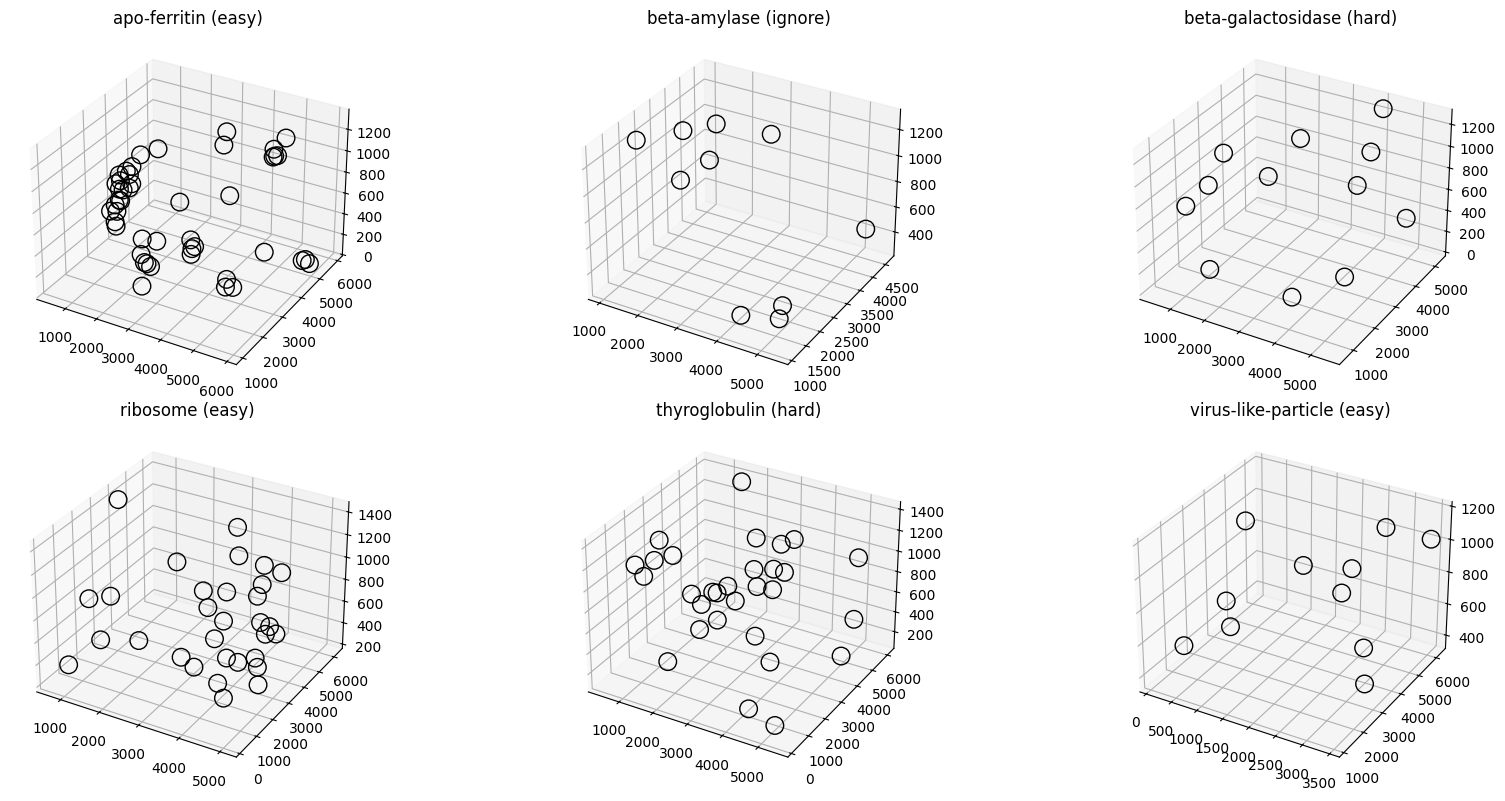

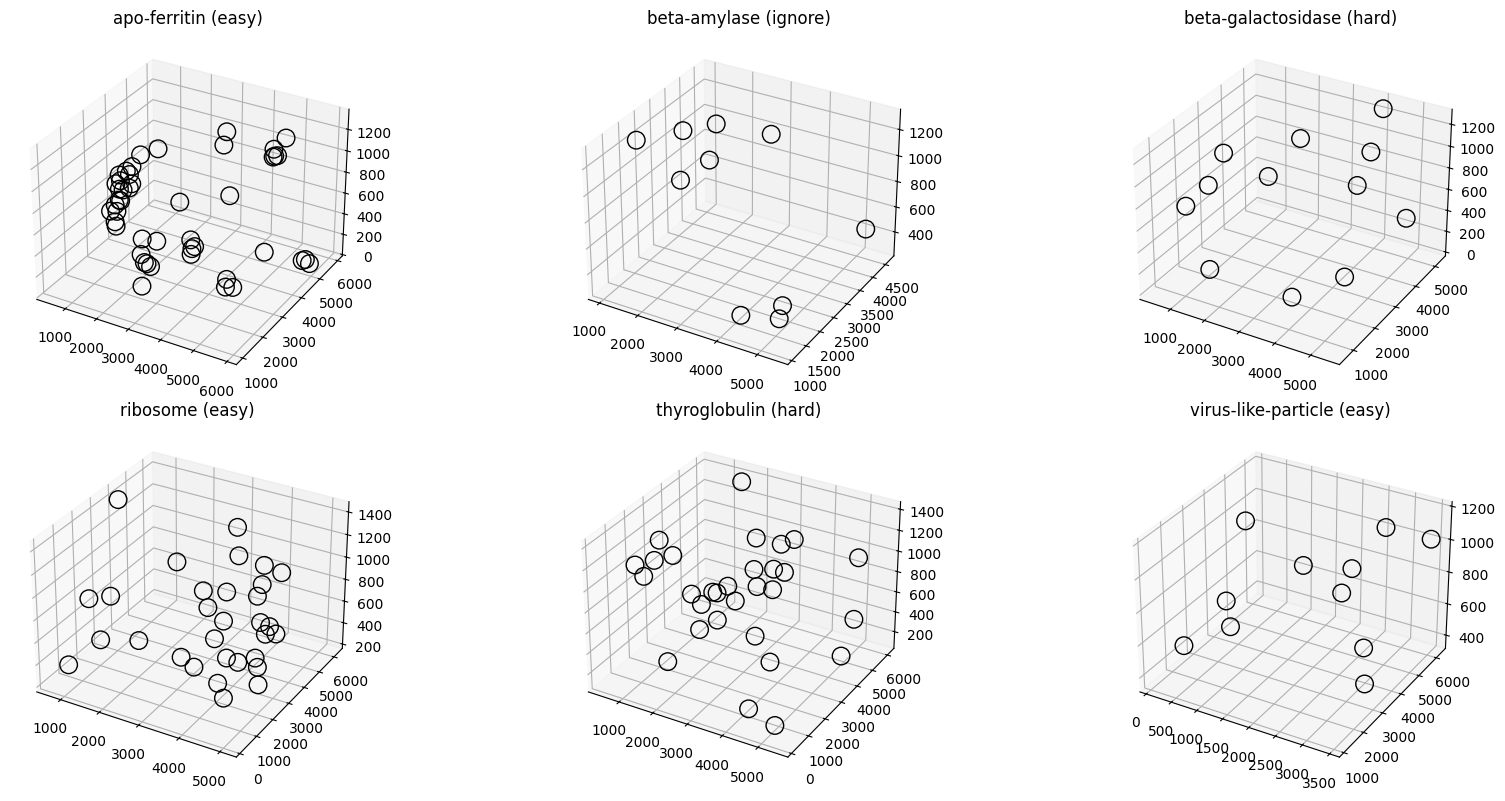

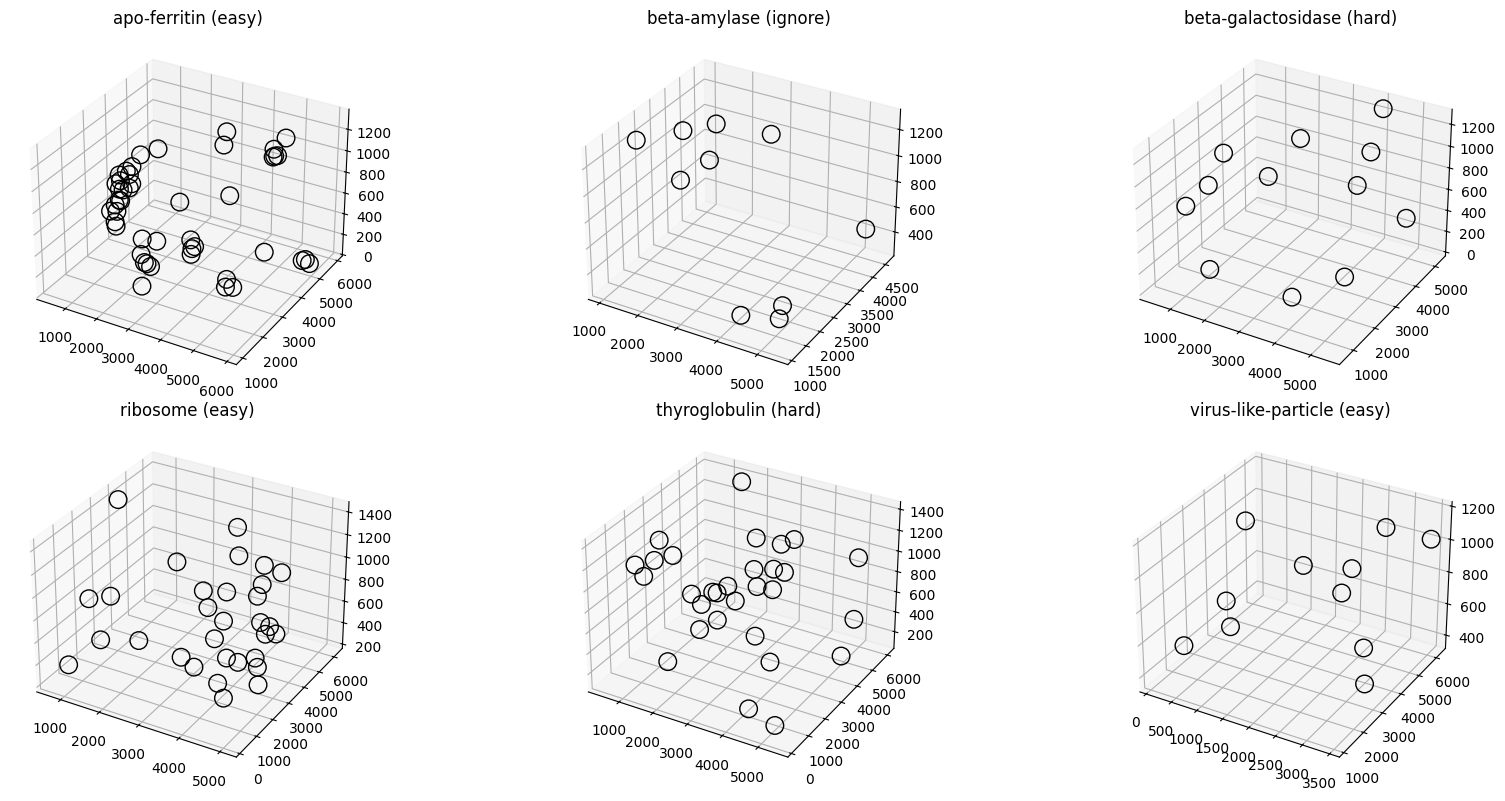

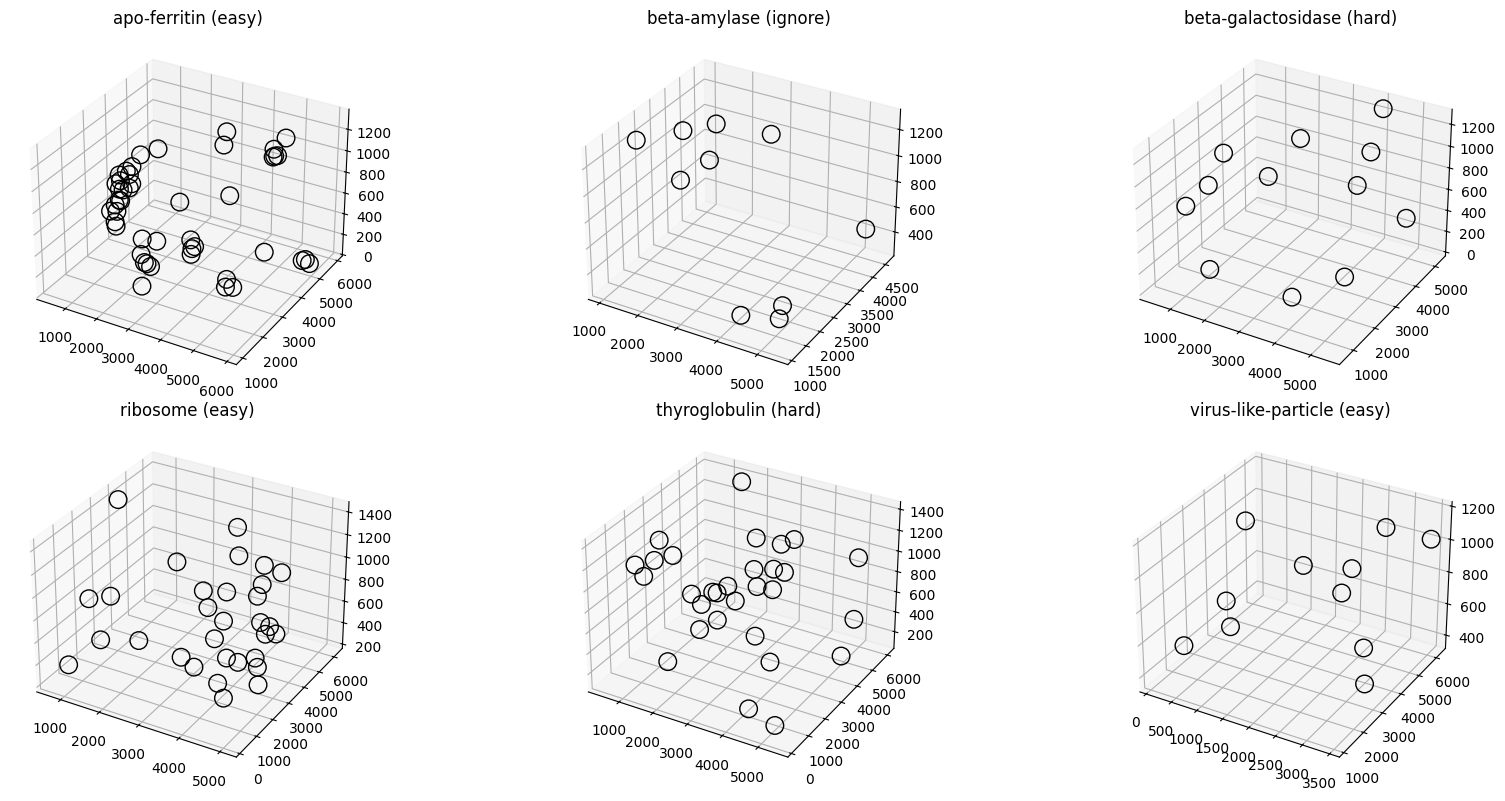

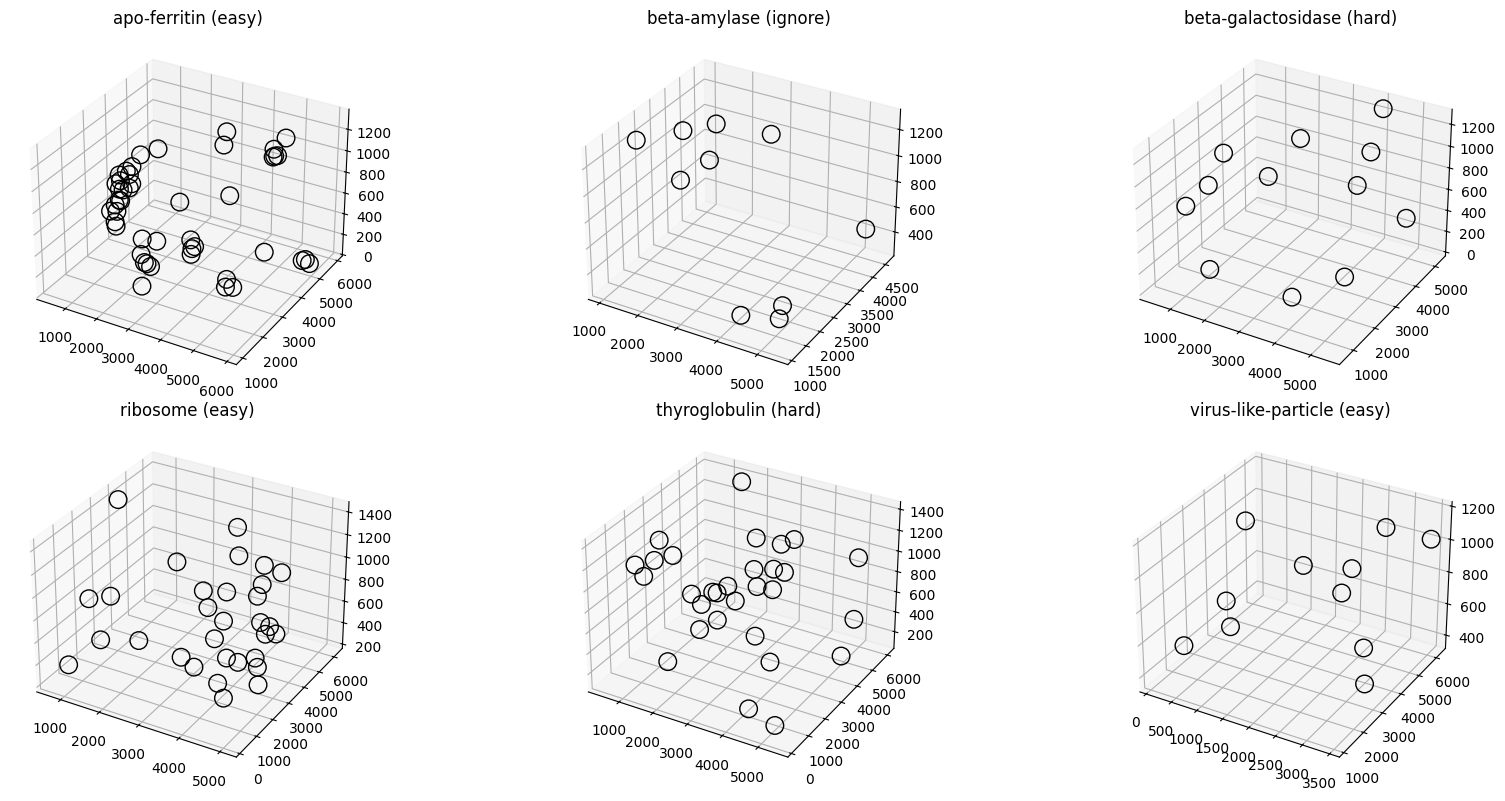

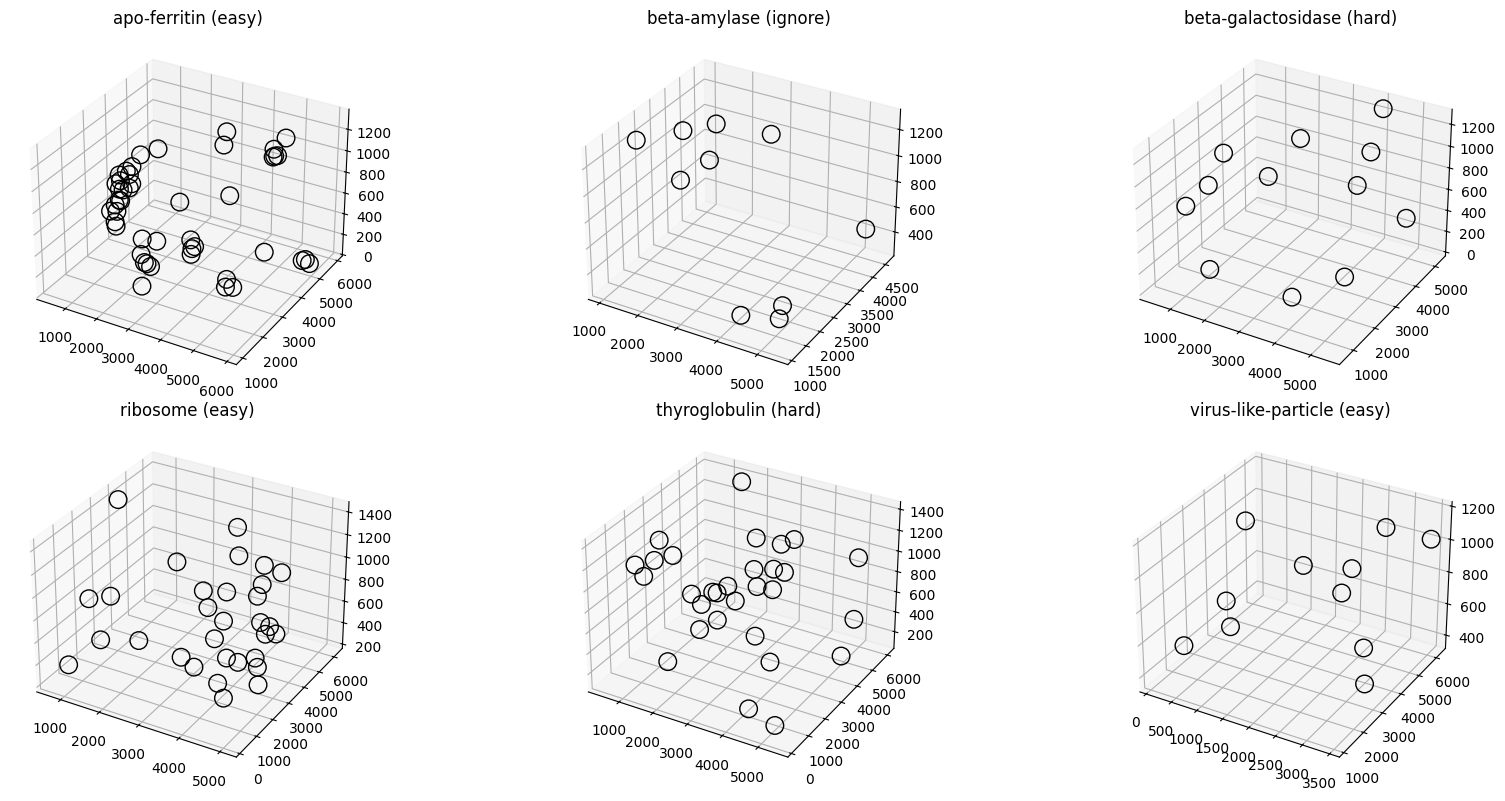

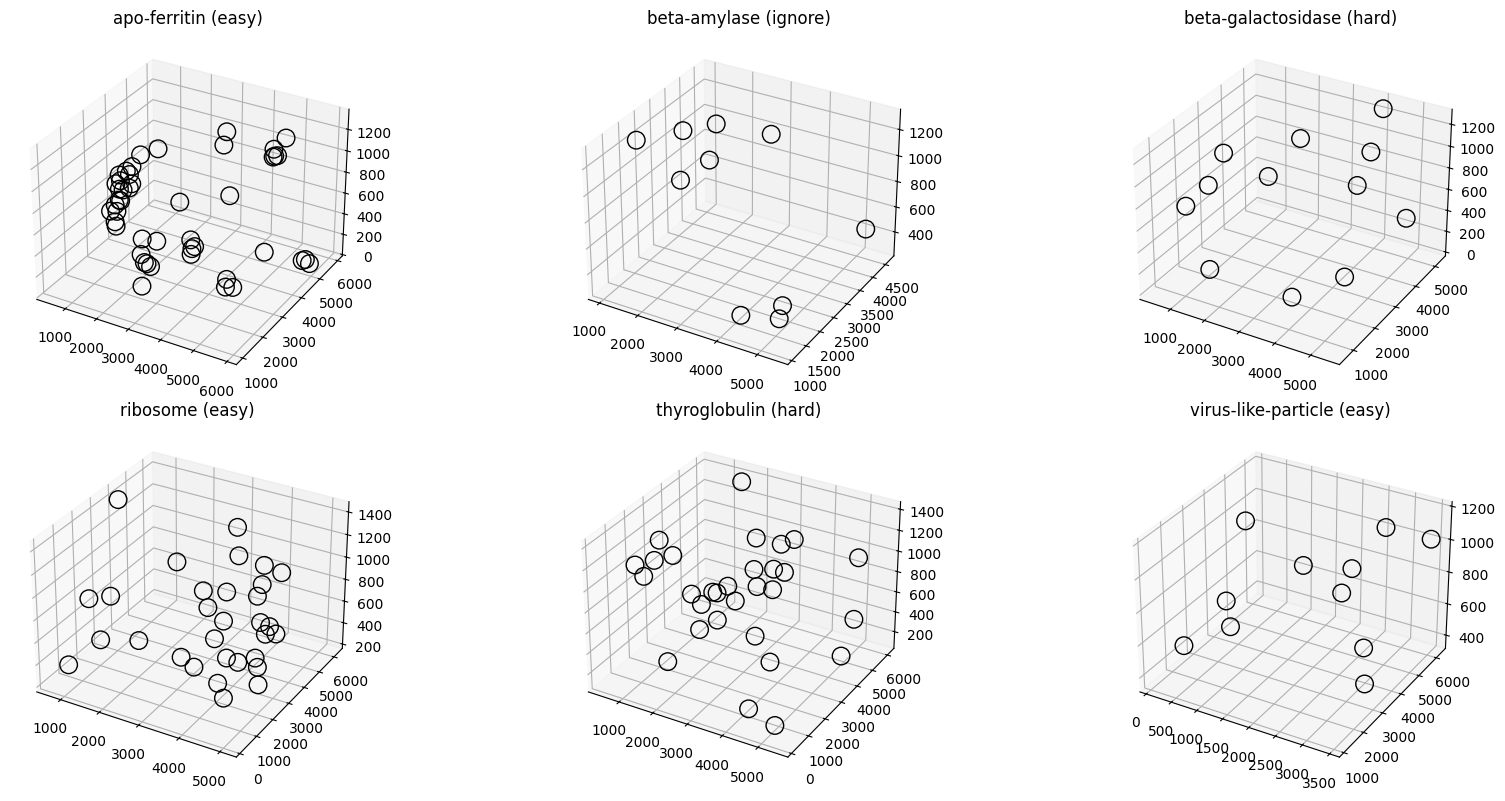

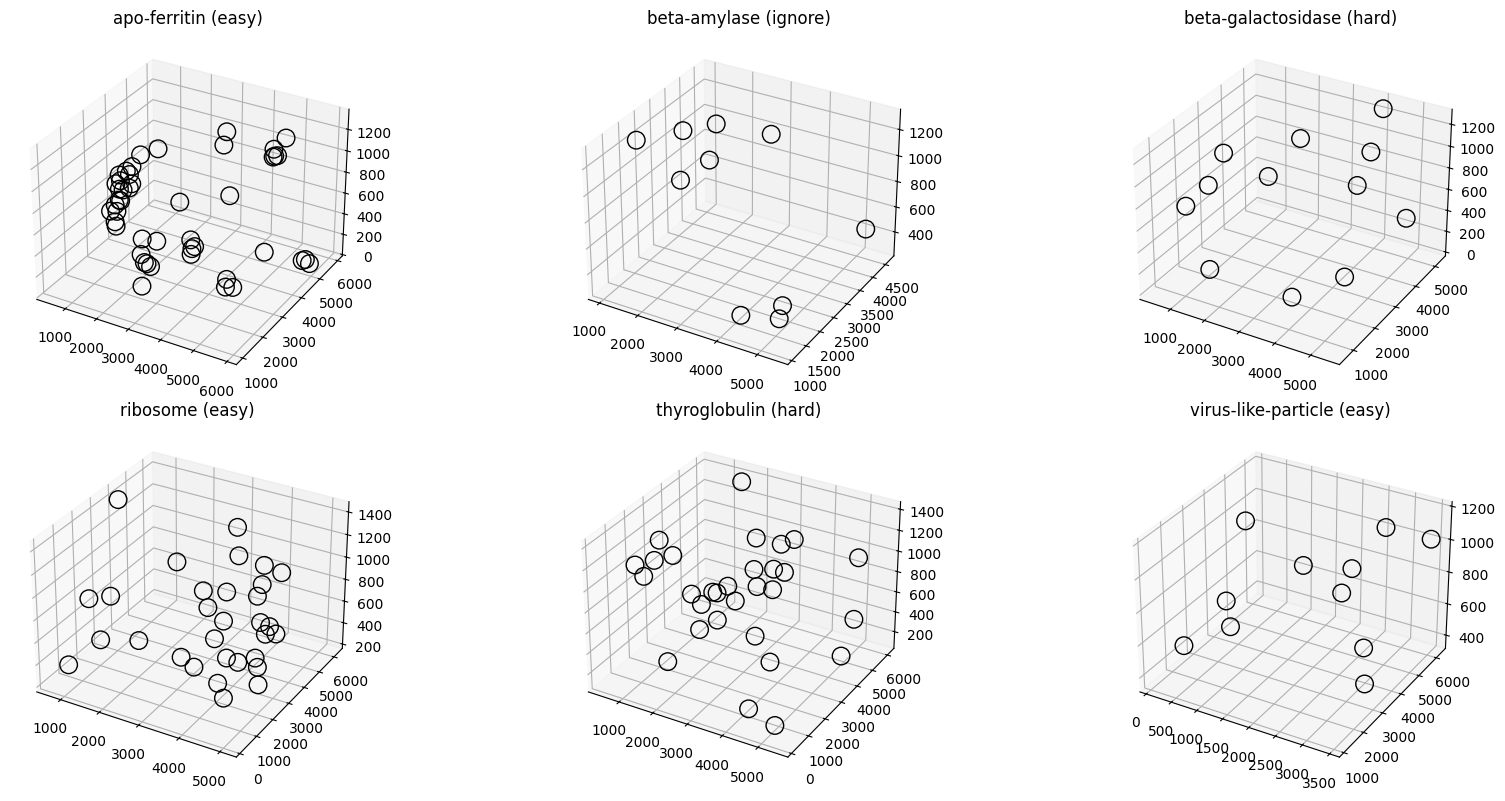

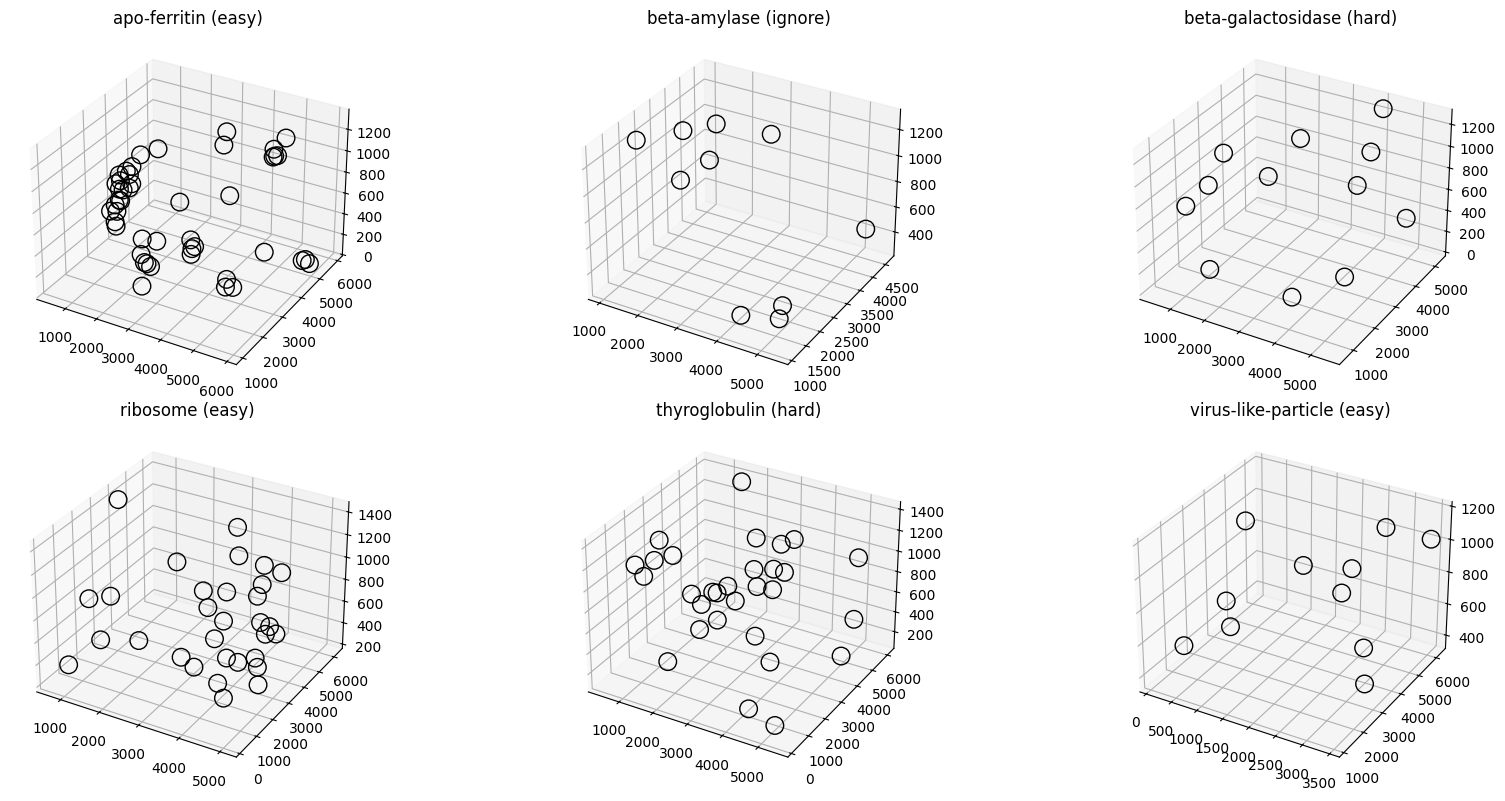

In [11]:
best_loss = 1e9
# epochループの前に、ログ用のリストを初期化
train_log = []
valid_log = []
df_lb_score = pd.DataFrame(columns=["lb_score"])

for epoch in range(100):
    print(f"epoch: {epoch}")
    train_loss = train_one_epoch()
    valid_loss, df = valid_one_epoch()
    print(f"train_loss: {train_loss}, valid_loss: {valid_loss}")

    # ログを記録
    train_log.append(train_loss)
    valid_log.append(valid_loss)
    
    # CSVファイルとして保存
    log_df = pd.DataFrame({
        'epoch': range(len(train_log)),
        'train_loss': train_log,
        'valid_loss': valid_log
    })
    log_df.to_csv('../proc/2-5d-model/training_log.csv', index=False)

    best_loss = min(best_loss, valid_loss)

    if valid_loss == best_loss:
        torch.save(model.state_dict(), "../proc/2-5d-model/model_best.pth")
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"../proc/2-5d-model/model_{epoch}.pth")
        # 例外処理を追加
        try:  
            lb_score = check_eval(df)
        except Exception as e:
            print(f'エラーが発生しました: {e}')
            lb_score = 0.0
        df_lb_score.loc[epoch] = lb_score
        df_lb_score.to_csv('../proc/2-5d-model/lb_score.csv')

        # 10エポックごとにグラフを描画して保存
        plt.figure(figsize=(10,6))
        plt.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss')
        plt.plot(log_df['epoch'], log_df['valid_loss'], label='Valid Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('../proc/2-5d-model/loss_curve.png')
        plt.close()

# %%
torch.save(model.state_dict(), "../proc/2-5d-model/model_last.pth")
